In [1]:
# Instalar librarias necesarias
import sys
!{sys.executable} -m pip install scikit-image
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install pillow

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 13.8 MB 242 kB/s            
     |████████████████████████████████| 3.3 MB 117 kB/s            
     |████████████████████████████████| 1.9 MB 47 kB/s             
     |████████████████████████████████| 180 kB 106 kB/s            
     |████████████████████████████████| 16.8 MB 85 kB/s             
     |████████████████████████████████| 42.3 MB 198 kB/s            
     |████████████████████████████████| 6.9 MB 359 kB/s            
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.9 MB 183 kB/s            
     |████████████████████████████████| 895 kB 219 kB/s            
     |████████████████████████████████| 1.6 MB 241 kB/s            
Defaulting to user installation because normal site-packages is not writeable


In [2]:
#importar librerias 
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.filters import threshold_otsu
from skimage.measure import label

In [34]:
#Función para asignar un valor a un arreglo bidimensional
def assign(arr, x, y, value):
    arr[x][y] = value


# Función para agregar ruido sal y pimienta a una imagen con probabilidad variable
def noise_salt_and_pepper(img, prob):
    # Obtener la longitud del arreglo de la imagen w: ancho, h:largo
    w, h = img.shape
    # Crear un arreglo del tamaño de la imagen original inicializado en 0 para almacenar la imagen con ruido
    noised_img = np.zeros((w, h))
    # Función para obtener el valor de un pixel con o sin anomalía basado en la probabilidad como parámetro
    noise = lambda value, x, y: 0 if value < prob else (255 if value > 1-prob else img[x][y])
    # Lista comprimida anidada para asignar los valores correspondientes al arreglo de la imagen con ruido
    [[assign(noised_img, i, j, noise(random.random(), i, j)) for j in range(h)] for i in range(w)]
    # Retornar arreglo de la imagen con ruido
    return noised_img

# Umbralización de una Imagen para obtener una imáegn binaria
def thresholding(img, threshold):
    # Obtener la longitud del arreglo de la imágen w: ancho, h:largo
    w, h = img.shape
    # Crear un arreglo del tamaño de la imagen original inicializado en 0 para almacenar la imágen binaria
    thresholded_image = np.zeros((w, h))
    # Función para obtener el valor de un pixel basandose en su valor original respecto al umbral
    binarization = lambda value: 0 if value < threshold else 1
    # Lista comprimida anidada para asignar los valores correspondientes al arreglo de la imágen binaria
    [[assign(thresholded_image, i, j, binarization(img[i][j])) for j in range(h)] for i in range(w)]
    return thresholded_image

# Función de filtrado espacial paso baja con-kernel variable (x, y)
def low_pass(img, kernel):
    w, h = img.shape
    kw, kh = kernel.shape
    if kw % 2==1 and kh%2 ==1:
        padw = kw//2
        padh = kh//2
        temp_img = np.pad(img,((padw, padw), (padh, padh)),'edge')
        filtered_image = np.zeros((w, h))
        total = kernel.sum()
        weighted_average = lambda x,y: int(np.sum(kernel*temp_img[x:x+padw*2+1, y:y+padh*2+1])/total)
        [[assign(filtered_image, i, j, weighted_average(i, j)) for j in range(h)] for i in range(w)]
        return filtered_image
    return img

# Función de filtrado espacial paso-alta con kernel variable (x, y)
def high_pass(img, kernel):
    w, h = img.shape
    kw, kh = kernel.shape
    filtered_image = np.zeros((w, h))
    if kw%2!=0:
        padw = kw//2
        padh = kh//2
        temp_img = np.pad(img,((padw, padw), (padh, padh)),'edge')
        product_sum = lambda x,y: np.sum(kernel*temp_img[x:x+padw*2+1, y:y+padh*2+1])
    else:
        temp_img = np.pad(img,((0, kw), (0, kh)),'edge')
        product_sum = lambda x,y: np.sum(kernel*temp_img[x:x+kw, y:y+kh])    
    [[assign(filtered_image, i, j, product_sum(i, j)) for j in range(h)] for i in range(w)]
    return filtered_image

# Operador de Roberts para detección de bordes diagonales
def roberts(img, orientation=True):
    if orientation:
        kernel = np.array(
            [[1, 0],
             [0, -1]]
        )
    else:
        kernel = np.array(
            [[0, 1],
             [-1, 0]]
        )
    return high_pass(img, kernel)

# Operador de Prewitt para la detección de bordes verticales y horizontales
def prewitt(img, orientation=True):
    if orientation:
        kernel = np.array(
    [[-1, 0, 1],
     [-1, 0, 1],
     [-1, 0, 1]])
    else:
        kernel = np.array(
    [[ 1,  1,  1],
     [ 0,  0,  0],
     [-1, -1, -1]])
    return high_pass(img, kernel)

# Operador de Sobel para la detección de bordes verticales y horizontales
# A diferencia de Prewitt, este operador da un mayor peso a los pixeles más cercanos al pixel de interés
def sobel(img, orientation=True):
    if orientation:
        kernel = np.array(
    [[-1, 0, 1],
     [-2, 0, 2],
     [-1, 0, 1]])
    else:
        kernel = np.array(
    [[ 1,  2,  1],
     [ 0,  0,  0],
     [-1, -2, -1]])
    return high_pass(img, kernel)

# Función para Unir el elemento estructural a la imagen en el pixel indicado (x, y)
def apply_structuring_element(img, kernel, x, y, w, h, kw, kh, padw, padh):
    if kw%2==1 and kh%2==1:
        for i in range(kw):
            for j in range(kh):
                pos_x = i + x - padw
                pos_y = j + y -padh
                if pos_x < 0 or pos_y < 0 or pos_x >= w or pos_y >= h:
                    continue
                img[pos_x][pos_y] = 1 if kernel[i][j] + img[pos_x][pos_y] > 0 else 0 

# Operador Morfológico Dilatación con elemento estructural variable
def dilation(img, kernel):
    w, h = img.shape
    kw, kh = kernel.shape
    filtered_image = np.zeros((w, h))
    padw = kw//2
    padh = kh//2
    [[apply_structuring_element(filtered_image, kernel, i, j, w, h, kw, kh, padw, padh) if img[i][j]!=0 else None for j in range(h)] for i in range(w)]
    return filtered_image

# Función para eliminar los pixeles que no coinciden con el elemento estructural
def remove_structuring_element(img, filtered_image, kernel, kernel_sum, x, y, w, h, kw, kh, padw, padh):
    if kw%2==1 and kh%2==1:
        for i in range(kw):
            for j in range(kh):
                pos_x = i + x - padw
                pos_y = j + y - padh
                if pos_x < 0 or pos_y < 0 or pos_x >= w or pos_y >= h:
                    continue
                if np.sum(kernel*img[pos_x:pos_x+padw*2+1, pos_y:pos_y+padh*2+1])!=kernel_sum:
                    if kernel[i][j] > 0:
                        filtered_image[pos_x][pos_y] = 0

# Operador Morfológico Erosión
def erosion(img, kernel):
    w, h = img.shape
    kw, kh = kernel.shape
    padw = kw//2
    padh = kh//2
    filtered_image = np.copy(img)
    temp_image = np.pad(img,((padw, padw), (padh, padh)),'edge')
    kernel_sum = np.sum(kernel)
    [[remove_structuring_element(temp_image, filtered_image, kernel, kernel_sum, i, j, w, h, kw, kh, padw, padh) for j in range(h)] for i in range(w)]
    return filtered_image

# Operador Morfológico de Cerradura con elemento estructural variable
def closing(img, kernel, dilated_img=None):
    if dilated_img is None:
        return erosion(dilation(img, kernel), kernel)
    return erosion(dilated_img, kernel)

# Operador Morfológico de Apertura con elemento estructural variable
def opening(img, kernel, eroded_img=None):
    if eroded_img is None:
        return dilation(erosion(img, kernel), kernel)
    return dilation(eroded_img, kernel)

# Operador Morfológico Gradiente con elemento estructural variable
def gradient(img, kernel, dilated_img=None, eroded_img=None):
    dilated = dilated_img
    if dilated is None:
        dilated = dilation(img, kernel)
    eroded = eroded_img
    if eroded is None:
        eroded = erosion(img, kernel)
    return  dilated - eroded 

# Operador Morfológico TopHat con elemento estructural variable
def tophat(img, kernel, opened_img=None):
    w, h = img.shape
    opened = opened_img
    if opened is None:
        opened = opening(img, kernel)
    return img-opened

# Invertir Imágen
def inverse(img):
    w, h = img.shape
    temp_image = np.zeros((w, h))
    [[assign(temp_image, i, j, 1) if img[i][j]==0 else None for j in range(h)] for i in range(w)]
    return temp_image

In [46]:
ker = np.array(
    [[1, 1, 1, 1 ,1],
     [1, 1, 1, 1 ,1],
     [1, 1, 1, 1 ,1],
     [1, 1, 1, 1 ,1],
     [1, 1, 1, 1 ,1]])

a, b = 3, 3
n = 3
r = 2

y,x = np.ogrid[-a:n-a, -b:n-b]
mask = x*x + y*y <= r*r

array = np.zeros((n, n))
array[mask] = 1

# Función para leer imágen y aplicar filtros
def read_img(path, thresh=None, kernel=ker, w=20, h=30):
    # Leer imagen original
    image1 = Image.open(path)
    # Convertir imagen a escala de grises para tratar un solo canal
    image1 = image1.convert("L")
    if thresh is None:
        thresh = threshold_otsu(np.asarray(image1))
    # Umbralizar imágen
    image2 = thresholding(np.asarray(image1), thresh)
    image2 = inverse(image2)
    # Erosionar imágen
    eroded = erosion(image2, kernel)
    # Apertura de Imagen
    image3 = opening(image2, kernel, eroded)
    # Operador TopHat
    image4 = gradient(image3, kernel, None, eroded)
    # Mostrar Imagenes en una matriz de (2,2)
    fig, (ax1, ax2) = plt.subplots(2,2, figsize=(w, h))
    # Mostrar imagen Original
    ax1[0].title.set_text("Imagen Umbralizada")
    ax1[0].axis("off")
    ax1[0].imshow(image2, cmap='gray')
    # Mostrar imagen Erosionada
    ax1[1].title.set_text("Imagen Erosionada")
    ax1[1].axis("off")
    ax1[1].imshow(eroded, cmap='gray')
    # Mostrar imagen con Apertura
    ax2[0].title.set_text("Dilatación")
    ax2[0].axis("off")
    ax2[0].imshow(image3, cmap='gray')
    # Mostrar imagen con operador TopHay
    ax2[1].title.set_text("Gradient")
    ax2[1].axis("off")
    ax2[1].imshow(image4, cmap='gray')

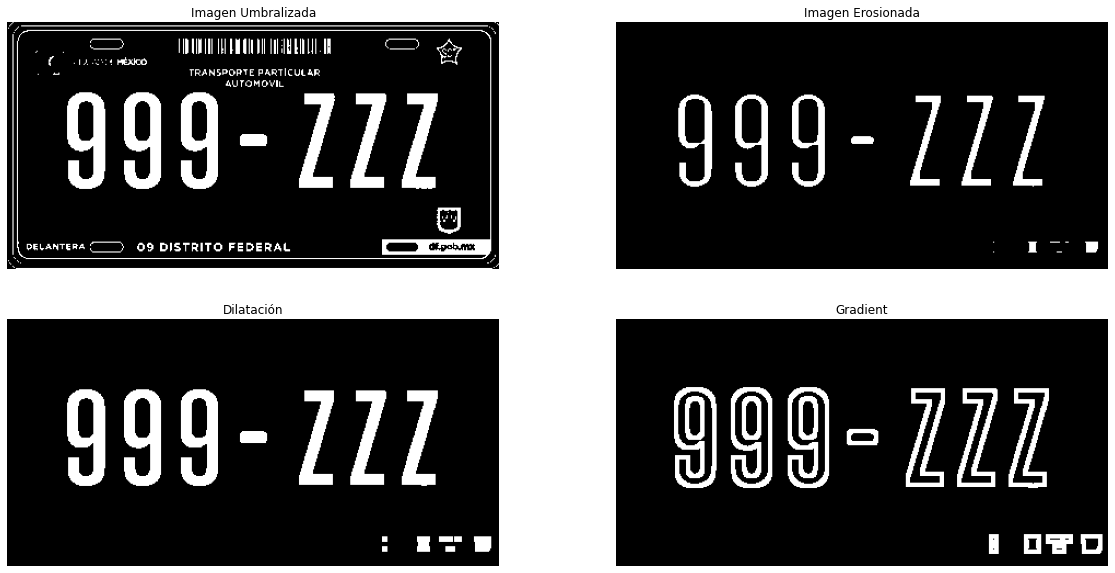

In [47]:
# Aplicar Filtros a Imágen monedas
read_img('imagenes/placas.jpg', None, ker, 20,10)